In [1]:
using Plots

In [2]:
### Object declaration
mutable struct Particle
    # Position
    x::Number
    y::Number
    # Velocity
    v_x::Number
    v_y::Number
    # Other properties: mass, charge
    m::Number
    q::Number
    
    # Constructors
    Particle(x, y, v_x, v_y, m, q) = new(x, y, v_x, v_y, m, q)
    Particle(x, y, v_x, v_y) = new(x, y, v_x, v_y, 1, 0)
    Particle(arg, m, q) = new(arg[1], arg[2], arg[3], arg[4], m, q)
    
end

function phase_trajectories(p::Particle)
    return (p.x, p.y, p.v_x, p.v_y)
end
#particles = [Particle(i, 2*i, i, i, i, i) for i in 1:3]

phase_trajectories (generic function with 1 method)

In [3]:
function Base.:+(p::Particle, y)
    return Particle(p.x + y[1], p.y + y[2], p.v_x + y[3], p.v_y + y[4], p.m, p.q)
end

In [195]:
### Proportionality constants: 
### Coulomb potential & Lennard-Jones potential
κ = 1.
ε = 1.
###
### Particle cross section radius
σ = 0.05
### Restitution coefficient
ρ = 0.8
### Number of particles
N = 100
### Box dimensions
dims = (-1.,1.)
### Box effect [left, right, bottom, top], 1 = normal restitution, >1 = acceleration, <1 = decceleration
effect = (0.8, 0.8, 0.8, 0.8)
### ODE Solver:
method = "RK4"
### Maximum effective radius for force interaction
R = 1.


function step(particles, i, dt, method)
    position = zeros(4)
    p = particles[i]

    position = collisions(particles, i, dt)
    
    ### Trajectory and speed in the next step

    if method == "RK4"
        position = RK4(
            forces, 
            Particle(position, p.m, p.q), 
            particles,
            i,
            dt
        )
    elseif method == "Euler"
        position = Euler(
            forces, 
            Particle(position, p.m, p.q), 
            particles,
            i,
            dt
        )
    end
            
    return position
end


function forces(p1, p2; Coulomb=true, Lennard_Jones=true)
    a1, a2 = 0., 0.
    r = sqrt((p1.x-p2.x)^2 + (p1.y-p2.y)^2)
    if(Coulomb)
        (a1, a2) = [p1.x-p2.x, p1.y-p2.y] * p1.q*p2.q*κ/p1.m /r^3
    end
    if(Lennard_Jones)
        r = sqrt((p1.x-p2.x)^2 + (p1.y-p2.y)^2)
        (a1, a2) = [a1, a2] + 
                   [-ε*(p1.x - p2.x)*(-12*σ^12 / r^7 + 6*σ^6 / r^4),
                    -ε*(p1.y - p2.y)*(-12*σ^12 / r^7 + 6*σ^6 / r^4)]
    end
    
    #return [a1, a2]
    return [p1.v_x, p1.v_y, a1, a2]
end


function forces(p1, index, particles; Coulomb=true, Lennard_Jones=false)
    a1, a2 = 0., 0.
    
    ### Adding up increments of forces induced by other particles
    for (i, p2) in enumerate(particles)
        if (index != i)
            r = sqrt((p1.x-p2.x)^2 + (p1.y-p2.y)^2)
            ### Effective radius
            if (r < R)
                if(Coulomb)
                    (a1, a2) = [p1.x-p2.x, p1.y-p2.y] * p1.q*p2.q*κ/p1.m /r^3
                end
                if(Lennard_Jones)
                    (a1, a2) = [a1, a2] + 
                               [-ε*(p1.x - p2.x)*(-12*σ^12 / r^7 + 6*σ^6 / r^4),
                                -ε*(p1.y - p2.y)*(-12*σ^12 / r^7 + 6*σ^6 / r^4)]
                end
            end
        end
    end
    return [p1.v_x, p1.v_y, a1, a2]
end


function trajectories(particles, t_range::Tuple, N, method)
    dt = (t_range[2] - t_range[1])/N
    trajectories = zeros(N + 1, 4 * length(particles))
    for (index, p) in enumerate(particles)
        trajectories[1, (4*index-3):(4*index)] .= [p.x, p.y, p.v_x, p.v_y]
    end

    for i in 2:(N + 1)
        for (index, p) in enumerate(particles)               
            ### Boundary effects
            box(p, dt, effect) 
            ### Complete trajectories
            trajectories[i,(4*index-3):(4*index)] .= step(particles, index, dt, method)  
        end
        
        ### Save trajectory into particles
        for (index, p) in enumerate(particles)               
            (p.x, p.y, p.v_x, p.v_y) = trajectories[i, (4*index-3):(4*index)]   
        end

    end
    
    return trajectories
end


function collisions(particles, i, dt)
    p = particles[i]
    for (index, p_other) in enumerate(particles)
        if (index != i)
            if(is_collision(p, p_other,dt))
                (vx, vy) = direction(p, p_other)
                v = vx^2 + vy^2
                ### If v == 0 then division by zero
                if (v <= 0.000001)
                    return [p.x, p.y, vx, vy]
                else
                    ### Set position and velocity (position in the direction
                    ### of the velocity unit vector)
                    direction_v = 1/sqrt(v)*[vx, vy]
                    return [
                        p.x+direction_v[1]*σ*dt,
                        p.y+direction_v[2]*σ*dt, 
                        vx, 
                        vy
                    ]
                end
            end
        end
    end
    return [p.x, p.y, p.v_x, p.v_y]
end 


function is_collision(p1, p2, dt)
    return ((p1.x+p1.v_x*dt-p2.x-p2.v_x*dt)^2 + 
            (p1.y+p1.v_y*dt-p2.y-p2.v_y*dt)^2 < σ^2)
end


### Change of particle momentum
function direction(p1, p2)
    μ = p1.m + p2.m
    v_x = (p1.m * p1.v_x + p2.m * p2.v_x) / μ
    v_y = (p1.m * p1.v_y + p2.m * p2.v_y) / μ
    pv = [
        v_x - p2.m * ρ * (p1.v_x - p2.v_x) / μ,
        v_y - p2.m * ρ * (p1.v_y - p2.v_y) / μ
    ]
    return pv
    
end


### Borders
function box(p, dt, effect)
    px, py, pvx, pvy = p.x, p.y, p.v_x, p.v_y
    if (px <= dims[1]) 
        p.v_x = -p.v_x*effect[1]
        p.x = dims[1]
    end
    if (px >= dims[2])
        p.v_x = -p.v_x*effect[2]
        p.x = dims[2]
    end
    if (py <= dims[1])
        p.v_y = -p.v_y*effect[3]
        p.y = dims[1]
    end
    if (py >= dims[2])
        p.v_y = -p.v_y*effect[4]
        p.y = dims[2]
    end
end


### Randomly generate particles by criteria
function create_particles(N, μ, charges)
    particles = []
    for i in 1:N
        distr = random_distribution(μ)
        ### Random position and velocity
        x, y, vx, vy = distr[1][1], distr[1][2], distr[2][1], distr[2][2]
        if (charges)
            p = Particle(x, y, vx, vy, 1, rand((-1:1)))
        else
            p = Particle(x, y, vx, vy)
        end
        push!(particles, p)
    end
    return particles
end


function maxwell_distribution(N, μ)
    f(v) = sqrt(1/π)*exp(-(v - μ)^2)

    velocities = []
    
    for i in 1:N
        
    end
end


function random_distribution(μ)
    position = (dims[2]-dims[1]-4*σ)*rand(Float64, (2,1)) + (dims[1]+2*σ)*[1,1]
    velocity = (2*μ-4*σ)*rand(Float64, (2,1)) + (-μ+2*σ)*[1,1]
    return [position, velocity]
end


### Create particle grid for targets, a == x length, b == y length
function create_grid()
    particles = []
    for j in 0:7
        for k in 0:4
            push!(particles, Particle(-0.35 + 0.1*j, -k*0.1, 0, 0, 1, 0))
        end
    end
    return particles
end

function RK4(f, p1, particles, i, dt)
    k1 = f(p1, i, particles)
    k2 = f(p1 + dt*k1/2, i, particles)
    k3 = f(p1 + dt*k2/2, i, particles)
    k4 = f(p1 + dt*k3, i, particles)
    
    return phase_trajectories(p1 + dt*(k1 + 2*k2 + 2*k3 + k4)/6)
end

function Euler(f, p1, particles, i, dt)
    return phase_trajectories(p1 + dt*f(p1, i, particles))
end

Euler (generic function with 1 method)

In [196]:
particles = create_particles(5, 1., true)
particles = [Particle(0.5, 0.5, 0, 0, 1, -1), Particle(0.5, 0, 0, 0, 1, -1)]
particles = create_grid()
push!(particles, Particle(0, 0.5, 0.3, -3, 1, 1))

41-element Array{Any,1}:
 Particle(-0.35, 0.0, 0, 0, 1, 0)
 Particle(-0.35, -0.1, 0, 0, 1, 0)
 Particle(-0.35, -0.2, 0, 0, 1, 0)
 Particle(-0.35, -0.30000000000000004, 0, 0, 1, 0)
 Particle(-0.35, -0.4, 0, 0, 1, 0)
 Particle(-0.24999999999999997, 0.0, 0, 0, 1, 0)
 Particle(-0.24999999999999997, -0.1, 0, 0, 1, 0)
 Particle(-0.24999999999999997, -0.2, 0, 0, 1, 0)
 Particle(-0.24999999999999997, -0.30000000000000004, 0, 0, 1, 0)
 Particle(-0.24999999999999997, -0.4, 0, 0, 1, 0)
 Particle(-0.14999999999999997, 0.0, 0, 0, 1, 0)
 Particle(-0.14999999999999997, -0.1, 0, 0, 1, 0)
 Particle(-0.14999999999999997, -0.2, 0, 0, 1, 0)
 ⋮
 Particle(0.15000000000000002, -0.4, 0, 0, 1, 0)
 Particle(0.2500000000000001, 0.0, 0, 0, 1, 0)
 Particle(0.2500000000000001, -0.1, 0, 0, 1, 0)
 Particle(0.2500000000000001, -0.2, 0, 0, 1, 0)
 Particle(0.2500000000000001, -0.30000000000000004, 0, 0, 1, 0)
 Particle(0.2500000000000001, -0.4, 0, 0, 1, 0)
 Particle(0.3500000000000001, 0.0, 0, 0, 1, 0)
 Particle(0.35000

In [197]:
sol = trajectories(particles, (0,3), 400)

401×164 Array{Float64,2}:
 -0.35  0.0  0.0  0.0  -0.35  -0.1  0.0  …   0.5       0.3        -3.0
 -0.35  0.0  0.0  0.0  -0.35  -0.1  0.0      0.4775    0.3        -3.0
 -0.35  0.0  0.0  0.0  -0.35  -0.1  0.0      0.455     0.3        -3.0
 -0.35  0.0  0.0  0.0  -0.35  -0.1  0.0      0.4325    0.3        -3.0
 -0.35  0.0  0.0  0.0  -0.35  -0.1  0.0      0.41      0.3        -3.0
 -0.35  0.0  0.0  0.0  -0.35  -0.1  0.0  …   0.3875    0.3        -3.0
 -0.35  0.0  0.0  0.0  -0.35  -0.1  0.0      0.365     0.3        -3.0
 -0.35  0.0  0.0  0.0  -0.35  -0.1  0.0      0.3425    0.3        -3.0
 -0.35  0.0  0.0  0.0  -0.35  -0.1  0.0      0.32      0.3        -3.0
 -0.35  0.0  0.0  0.0  -0.35  -0.1  0.0      0.2975    0.3        -3.0
 -0.35  0.0  0.0  0.0  -0.35  -0.1  0.0  …   0.275     0.3        -3.0
 -0.35  0.0  0.0  0.0  -0.35  -0.1  0.0      0.2525    0.3        -3.0
 -0.35  0.0  0.0  0.0  -0.35  -0.1  0.0      0.23      0.3        -3.0
  ⋮                            ⋮         ⋱         

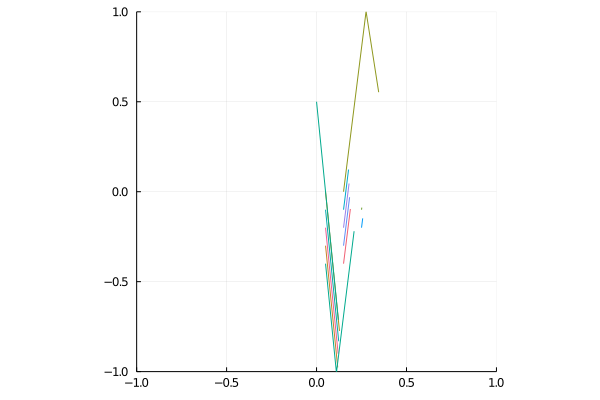

In [198]:
### Plot full trajectories
plot(sol[:,1], sol[:,2], lims=dims, aspect_ratio=:equal, label=false, legend=false)
for (index, p) in enumerate(particles)
    if index == 1
        continue
    end
    plot!(sol[:,(4*index-3)], sol[:,(4*index-2)])
end
current()


In [28]:

@userplot plot_particles
@recipe function f(cp::plot_particles, add_marker = true)
    x, y= cp.args

    aspect_ratio --> 1
    label --> false
    lims --> dims
    markershape --> :circle
    x, y

end



┌ Info: Saved animation to 
│   fn = /Users/tadeasnemec/Programming/Git/Particles_In_Box/particle_sim.gif
└ @ Plots /Users/tadeasnemec/.julia/packages/Plots/SjqWU/src/animation.jl:104


Plots.AnimatedGif("/Users/tadeasnemec/Programming/Git/Particles_In_Box/particle_sim.gif")
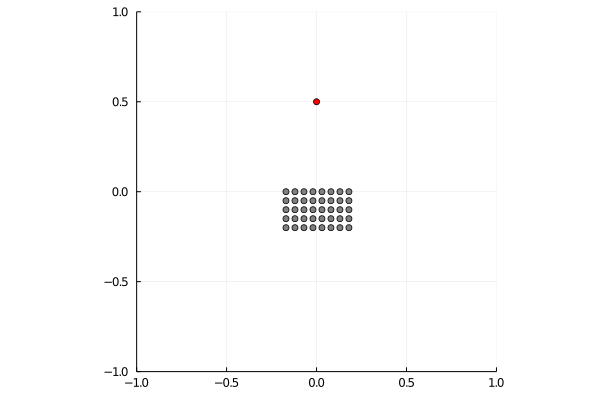

In [185]:
### Colors corresponding to charge:
colors = Dict(-1 => :blue, 0 => :gray, 1 => :red)

anim = @animate for i ∈ 1:length(sol[:,1])
    plot_particles(sol[i:i,1], sol[i:i,2], markercolor = colors[particles[1].q])
    for (index, p) in enumerate(particles)
        if index == 1
            continue
        end
        plot_particles!(sol[i:i,(4*index-3)], sol[i:i,(4*index-2)], markercolor = colors[p.q])
    end
end
gif(anim, "particle_sim.gif", fps = 70)


